In [24]:
from provided_code import generate_dataset_classification, generate_dataset_regression, visualize_prediction, generate_a_disk_2
import matplotlib.pyplot as plt
import numpy as np
#setting a seed for reproductibility
np.random.seed(777)
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, UpSampling2D, Input, Add
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import to_categorical
from keras import losses, callbacks, backend, regularizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
import math
%matplotlib inline

Jean-Baptiste REMY

# <center>Miniproject #1: Classification and Regression</center>

# Simple classification

In this section we want to determine if an image is a rectangle, a circle or a triangle. First, let's generate a training data set with 300 images of size 72x72.

## Generating training data

In [2]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


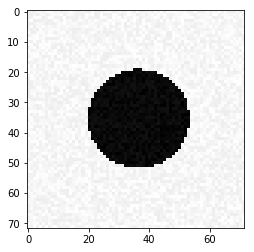

In [3]:
plt.imshow(X_train[0, :].reshape(72, 72), cmap='gray')

## Building a simple Neural Network

In order to run faster computations let's activate a GPU backend.

In [154]:
# Clearing session 
backend.clear_session()

# Usage of GPU
config = tf.ConfigProto(device_count={'GPU': 1 , 'CPU': 1}) 
sess = tf.Session(config=config)
backend.set_session(sess)

# Checking aviability
backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### SGD

Now lets creat a simple linear classifier. To avoid overfitting we add a dropout layer. By using a softmax + cross entropy we approximate the probability to be in one classe.

In [155]:
# Graph
model = Sequential([
    Dense(3, input_shape=(72*72,)),
    Dropout(rate=0.2),
    Activation('softmax')
]) 

# Optimizer
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss=losses.categorical_crossentropy, optimizer=sgd, metrics=['acc'])

# Callback for tensorboard
toCallback = callbacks.TensorBoard(log_dir='Networks\\Model_1\\logs', batch_size=32,
                                   write_graph=True, histogram_freq=1, write_grads=True)

Now we can fit a model. First Y_train needs to be one hot encoded.

In [156]:
# Y to one hot
Y_train_one_hot = to_categorical(Y_train)

# Fitting the model
model.fit(x=X_train, y=Y_train_one_hot, epochs=40, batch_size=4, validation_split=0.2, callbacks=[toCallback])

# Saving model
model.save('Networks\\Model_1\\Fitted_Network')

Train on 240 samples, validate on 60 samples
Epoch 1/40
240/240 [==============================] - 1s 2ms/step - loss: 1.0589 - acc: 0.4750 - val_loss: 0.7921 - val_acc: 0.7000
Epoch 2/40
240/240 [==============================] - 0s 1ms/step - loss: 0.7457 - acc: 0.6583 - val_loss: 0.5908 - val_acc: 0.7667
Epoch 3/40
240/240 [==============================] - 0s 1ms/step - loss: 0.6147 - acc: 0.7375 - val_loss: 0.6140 - val_acc: 0.8000
Epoch 4/40
240/240 [==============================] - 0s 1ms/step - loss: 0.5485 - acc: 0.7958 - val_loss: 0.4154 - val_acc: 0.8667
Epoch 5/40
240/240 [==============================] - 0s 1ms/step - loss: 0.5004 - acc: 0.8167 - val_loss: 0.3820 - val_acc: 0.9167
Epoch 6/40
240/240 [==============================] - 0s 1ms/step - loss: 0.4411 - acc: 0.8333 - val_loss: 0.3896 - val_acc: 0.8667
Epoch 7/40
240/240 [==============================] - 0s 1ms/step - loss: 0.4603 - acc: 0.8125 - val_loss: 0.3337 - val_acc: 0.9167
Epoch 8/40
240/240 [===========

Training is over after 200 iterations. The training error seams poor, but it comes from the dropout. Condidering the problem we address, and the small intra-class variation, we could probably get rid of this step. We can evoluate performances on a test data set (even though we already have validation_accuracy).

In [168]:
[X_test, Y_test] = generate_dataset_classification(50, 20)
Y_test_one_hot = to_categorical(Y_test)
res = model.evaluate(X_test, Y_test_one_hot)
print('Test scores :')
print('loss : {:.2f} - Accuracy : {}'.format(res[0], res[1]))

Creating data:
0
10
20
30
40
50/50 [==============================] - 0s 140us/step
Test scores :
loss : 0.10 - Accuracy : 1.0


Estimated probs : 0.11, 0.89, 0.00
True class : 1


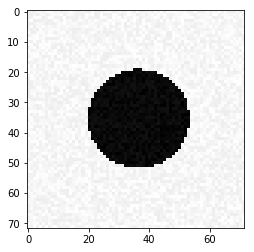

In [181]:
plt.imshow(X_test[0, :].reshape(72, 72), cmap='gray')
print('Estimated probs : {:.2f}, {:.2f}, {:.2f}'.format(*model.predict(X_test[0, :].reshape(1,72*72))[0].tolist()))
print('True class : {:1.0f}'.format(Y_test[0]))

### Adam

Now let's try the same model with an Adam optimizer

In [159]:
# Clearing session 
backend.clear_session()

# Graph
model = Sequential([
    Dense(3, input_shape=(72*72,)),
    Dropout(rate=0.2),
    Activation('softmax')
]) 

# Optimizer
adam = Adam(lr=0.0001, decay=1e-6)

model.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['acc'])

# Callback for tensorboard
toCallback = callbacks.TensorBoard(log_dir='Networks\\Model_2\\logs', batch_size=32,
                                   write_graph=True, histogram_freq=1, write_grads=True)

# Fitting the model
model.fit(x=X_train, y=Y_train_one_hot, epochs=40, batch_size=4, validation_split=0.2, callbacks=[toCallback])

# Saving model
model.save('Networks\\Model_2\\Fitted_Network')

Train on 240 samples, validate on 60 samples
Epoch 1/40
240/240 [==============================] - 1s 2ms/step - loss: 1.1829 - acc: 0.4083 - val_loss: 0.9129 - val_acc: 0.6333
Epoch 2/40
240/240 [==============================] - 0s 1ms/step - loss: 0.8609 - acc: 0.5833 - val_loss: 0.7617 - val_acc: 0.7167
Epoch 3/40
240/240 [==============================] - 0s 1ms/step - loss: 0.7894 - acc: 0.6042 - val_loss: 0.6588 - val_acc: 0.7500
Epoch 4/40
240/240 [==============================] - 0s 1ms/step - loss: 0.6787 - acc: 0.6833 - val_loss: 0.6115 - val_acc: 0.7500
Epoch 5/40
240/240 [==============================] - 0s 1ms/step - loss: 0.5877 - acc: 0.7708 - val_loss: 0.5177 - val_acc: 0.8167
Epoch 6/40
240/240 [==============================] - 0s 1ms/step - loss: 0.5565 - acc: 0.7625 - val_loss: 0.4682 - val_acc: 0.8667
Epoch 7/40
240/240 [==============================] - 0s 1ms/step - loss: 0.5087 - acc: 0.7875 - val_loss: 0.4278 - val_acc: 0.9000
Epoch 8/40
240/240 [===========

### Visualizing the weights matrix

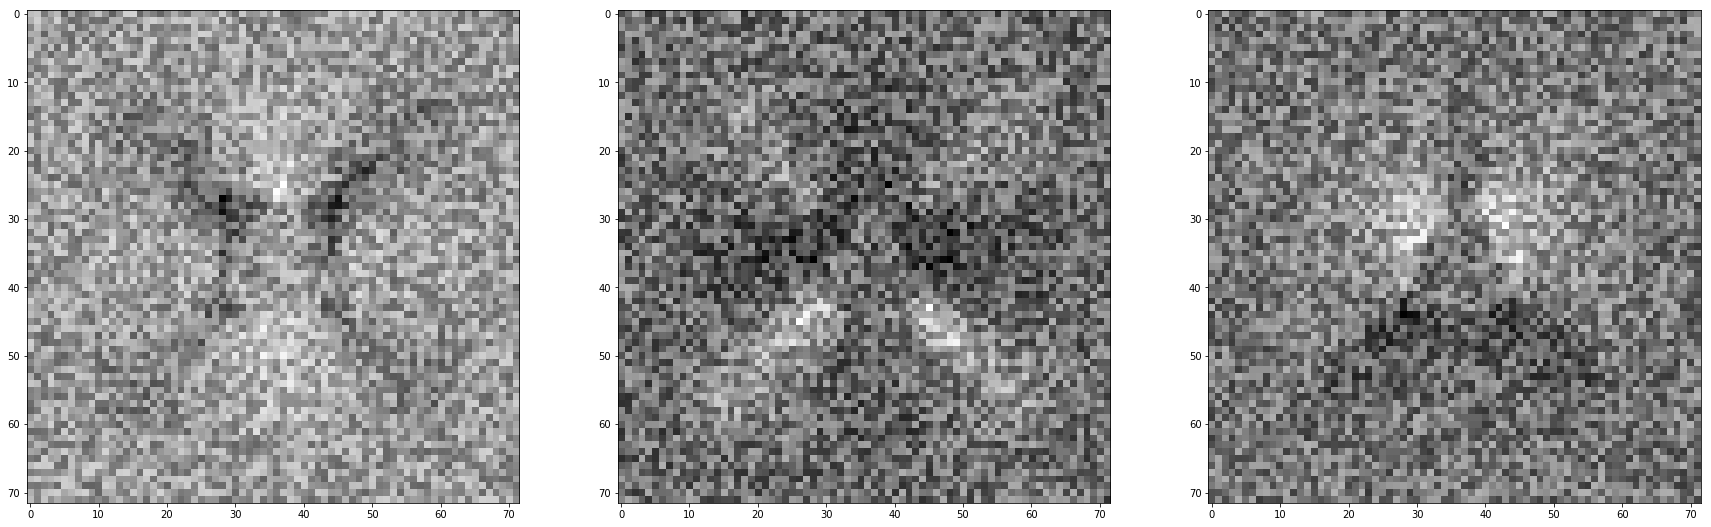

In [160]:
# Hidden layer weigths
fig, subs = plt.subplots(1,3, figsize=(30,10))
for _ in range(3):
    subs.flat[_].imshow(model.get_weights()[0][:,_].reshape(72,72), cmap='gray')

#  A More Difficult Classification Problem

Now we allow the object to moove in the image and to change dimension. Let's generate a new training set.

In [388]:
[X_train, Y_train] = generate_dataset_classification(500, 20, True)
Y_train_one_hot = to_categorical(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


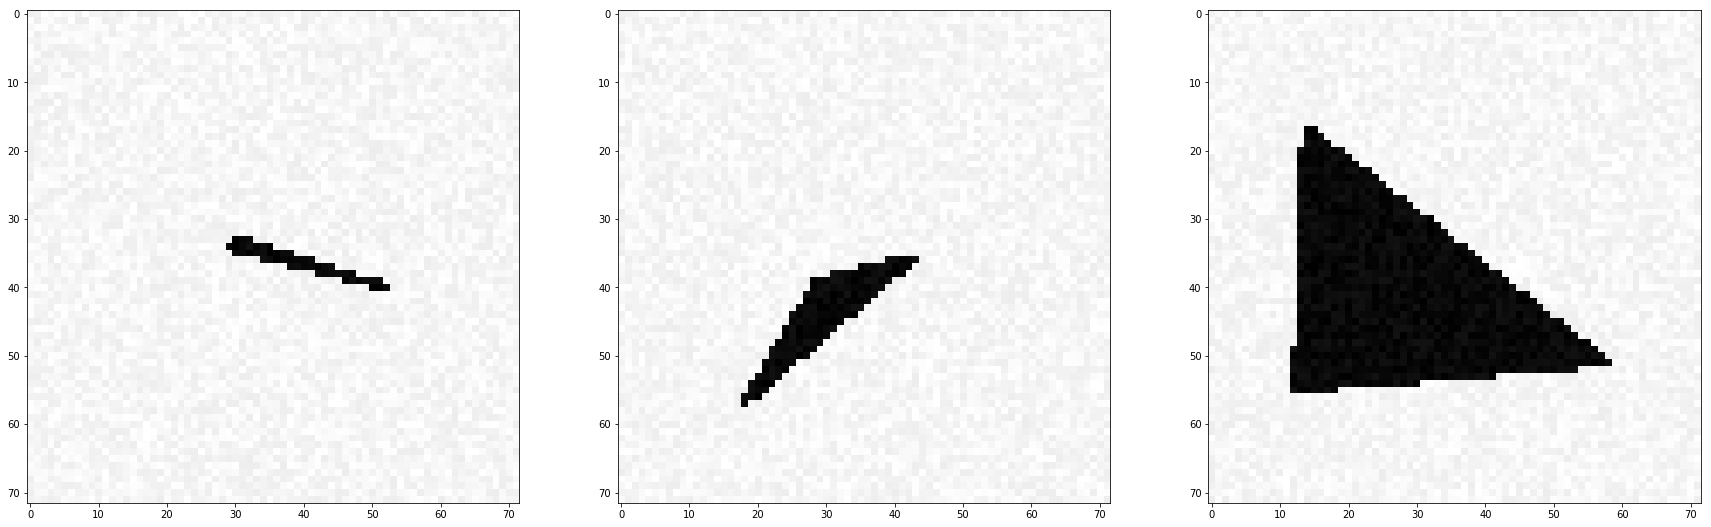

In [205]:
fig, subs = plt.subplots(1,3, figsize=(30,10))
for _ in range(3):
    subs.flat[_].imshow(X_train[_, :].reshape(72, 72), cmap='gray')

## Convolutional neural network

In [255]:
# Clearing session 
backend.clear_session()

# Graph
model = Sequential([
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu',
           input_shape=(72, 72, 1)), #
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(3),
    Activation('softmax')]
) 

# Optimizer
adam = Adam(lr=0.0001, decay=1e-5)

model.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['acc'])

# Callback for tensorboard
toCallback = callbacks.TensorBoard(log_dir='Networks\\Model_3\\logs', batch_size=32,
                                   write_graph=True)

# Data augmentation
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=True,
        fill_mode='nearest')

X_train = X_train.reshape(500, 72, 72, 1)

# Fitting the model
model.fit_generator(datagen.flow(X_train, Y_train_one_hot, batch_size=16),
          epochs=3000, callbacks=[toCallback])

# Saving model
model.save('Networks\\Model_3\\Fitted_Network')

Epoch 1/3000
32/32 [==============================] - 0s 12ms/step - loss: 1.1458 - acc: 0.3303
Epoch 2/3000
32/32 [==============================] - 0s 9ms/step - loss: 1.1064 - acc: 0.3671
Epoch 3/3000
32/32 [==============================] - 0s 9ms/step - loss: 1.0990 - acc: 0.3948
Epoch 4/3000
32/32 [==============================] - 0s 9ms/step - loss: 1.0825 - acc: 0.3827
Epoch 5/3000
32/32 [==============================] - 0s 9ms/step - loss: 1.0872 - acc: 0.3689
Epoch 6/3000
32/32 [==============================] - 0s 10ms/step - loss: 1.0811 - acc: 0.4003
Epoch 7/3000
32/32 [==============================] - 0s 9ms/step - loss: 1.0701 - acc: 0.4255
Epoch 8/3000
32/32 [==============================] - 0s 10ms/step - loss: 1.0508 - acc: 0.4042
Epoch 9/3000
32/32 [==============================] - 0s 8ms/step - loss: 1.0398 - acc: 0.4568
Epoch 10/3000
32/32 [==============================] - 0s 9ms/step - loss: 1.0347 - acc: 0.4687
Epoch 11/3000
32/32 [=========================

32/32 [==============================] - 0s 9ms/step - loss: 0.9124 - acc: 0.5688
Epoch 86/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.9319 - acc: 0.5705
Epoch 87/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.9159 - acc: 0.5725
Epoch 88/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.9208 - acc: 0.5897
Epoch 89/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.9145 - acc: 0.5782
Epoch 90/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.8974 - acc: 0.5995
Epoch 91/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.9002 - acc: 0.6036
Epoch 92/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.9078 - acc: 0.5569
Epoch 93/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.8994 - acc: 0.6073
Epoch 94/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.9071 - acc: 0.5842
Epoch 95/3000
32/32 [==============================

32/32 [==============================] - 0s 9ms/step - loss: 0.8265 - acc: 0.6525
Epoch 170/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.8371 - acc: 0.6405
Epoch 171/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.8482 - acc: 0.6310
Epoch 172/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.8594 - acc: 0.6386
Epoch 173/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.8417 - acc: 0.6114
Epoch 174/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.8431 - acc: 0.6484
Epoch 175/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.8649 - acc: 0.5997
Epoch 176/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.8680 - acc: 0.5979
Epoch 177/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.8528 - acc: 0.6249
Epoch 178/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.8400 - acc: 0.6171
Epoch 179/3000
32/32 [=======================

32/32 [==============================] - 0s 9ms/step - loss: 0.8184 - acc: 0.6331
Epoch 254/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7882 - acc: 0.6741
Epoch 255/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7826 - acc: 0.6661
Epoch 256/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7991 - acc: 0.6681
Epoch 257/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7842 - acc: 0.6736
Epoch 258/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.8443 - acc: 0.6487
Epoch 259/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.8004 - acc: 0.6466
Epoch 260/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.8125 - acc: 0.6505
Epoch 261/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7853 - acc: 0.6640
Epoch 262/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7939 - acc: 0.6525
Epoch 263/3000
32/32 [=======================

32/32 [==============================] - 0s 10ms/step - loss: 0.7702 - acc: 0.6503
Epoch 338/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7845 - acc: 0.6525
Epoch 339/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7542 - acc: 0.6970
Epoch 340/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7512 - acc: 0.6780
Epoch 341/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7576 - acc: 0.6720
Epoch 342/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7501 - acc: 0.6914
Epoch 343/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7697 - acc: 0.6583
Epoch 344/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7463 - acc: 0.6777
Epoch 345/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7394 - acc: 0.6875
Epoch 346/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7561 - acc: 0.6446
Epoch 347/3000
32/32 [======================

32/32 [==============================] - 0s 10ms/step - loss: 0.7511 - acc: 0.6775
Epoch 422/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7411 - acc: 0.6955
Epoch 423/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7475 - acc: 0.6487
Epoch 424/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7583 - acc: 0.6896
Epoch 425/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7223 - acc: 0.6914
Epoch 426/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7597 - acc: 0.6681
Epoch 427/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7081 - acc: 0.6931
Epoch 428/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7528 - acc: 0.6677
Epoch 429/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7542 - acc: 0.6816
Epoch 430/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7395 - acc: 0.6777
Epoch 431/3000
32/32 [======================

32/32 [==============================] - 0s 9ms/step - loss: 0.7241 - acc: 0.6912
Epoch 506/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7195 - acc: 0.7068
Epoch 507/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7011 - acc: 0.6974
Epoch 508/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7216 - acc: 0.6953
Epoch 509/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7140 - acc: 0.7129
Epoch 510/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7518 - acc: 0.6605
Epoch 511/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7101 - acc: 0.7049
Epoch 512/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7167 - acc: 0.7050
Epoch 513/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7385 - acc: 0.6757
Epoch 514/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7129 - acc: 0.6816
Epoch 515/3000
32/32 [=======================

32/32 [==============================] - 0s 10ms/step - loss: 0.6938 - acc: 0.7091
Epoch 590/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7168 - acc: 0.7049
Epoch 591/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7183 - acc: 0.7029
Epoch 592/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7522 - acc: 0.6779
Epoch 593/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6969 - acc: 0.7187
Epoch 594/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7035 - acc: 0.7225
Epoch 595/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7264 - acc: 0.6914
Epoch 596/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7073 - acc: 0.6931
Epoch 597/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7178 - acc: 0.7109
Epoch 598/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7182 - acc: 0.7013
Epoch 599/3000
32/32 [======================

32/32 [==============================] - 0s 9ms/step - loss: 0.7216 - acc: 0.7013
Epoch 674/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7191 - acc: 0.6759
Epoch 675/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.7166 - acc: 0.6894
Epoch 676/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.7177 - acc: 0.6818
Epoch 677/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7214 - acc: 0.6912
Epoch 678/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7277 - acc: 0.6622
Epoch 679/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7134 - acc: 0.7091
Epoch 680/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7252 - acc: 0.6757
Epoch 681/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6985 - acc: 0.7152
Epoch 682/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.7022 - acc: 0.7344
Epoch 683/3000
32/32 [===================

32/32 [==============================] - 0s 10ms/step - loss: 0.7037 - acc: 0.6894
Epoch 758/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.7106 - acc: 0.6990
Epoch 759/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6920 - acc: 0.6990
Epoch 760/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7114 - acc: 0.6605
Epoch 761/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7148 - acc: 0.6894
Epoch 762/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6985 - acc: 0.7170
Epoch 763/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7088 - acc: 0.6857
Epoch 764/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7310 - acc: 0.6759
Epoch 765/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7112 - acc: 0.7010
Epoch 766/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6981 - acc: 0.7070
Epoch 767/3000
32/32 [====================

32/32 [==============================] - 0s 10ms/step - loss: 0.6738 - acc: 0.7267
Epoch 841/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7078 - acc: 0.6935
Epoch 842/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7023 - acc: 0.7070
Epoch 843/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7259 - acc: 0.6878
Epoch 844/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6972 - acc: 0.7011
Epoch 845/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7174 - acc: 0.7170
Epoch 846/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7043 - acc: 0.6974
Epoch 847/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6912 - acc: 0.7109
Epoch 848/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6823 - acc: 0.7207
Epoch 849/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7019 - acc: 0.6955
Epoch 850/3000
32/32 [======================

32/32 [==============================] - 0s 9ms/step - loss: 0.7040 - acc: 0.7246
Epoch 925/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6870 - acc: 0.7129
Epoch 926/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6880 - acc: 0.6953
Epoch 927/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6945 - acc: 0.6835
Epoch 928/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6954 - acc: 0.6935
Epoch 929/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6998 - acc: 0.6974
Epoch 930/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6890 - acc: 0.6875
Epoch 931/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6663 - acc: 0.7305
Epoch 932/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6928 - acc: 0.6894
Epoch 933/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7077 - acc: 0.6857
Epoch 934/3000
32/32 [===================

32/32 [==============================] - 0s 10ms/step - loss: 0.6748 - acc: 0.7146
Epoch 1008/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6923 - acc: 0.7049
Epoch 1009/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6779 - acc: 0.7246
Epoch 1010/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6939 - acc: 0.6994
Epoch 1011/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6814 - acc: 0.6857
Epoch 1012/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.7025 - acc: 0.7111
Epoch 1013/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6860 - acc: 0.7049
Epoch 1014/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7005 - acc: 0.6972
Epoch 1015/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6817 - acc: 0.7031
Epoch 1016/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6764 - acc: 0.7205
Epoch 1017/3000
32/32 [=======

32/32 [==============================] - 0s 9ms/step - loss: 0.6818 - acc: 0.7248
Epoch 1091/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6995 - acc: 0.7091
Epoch 1092/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6799 - acc: 0.6914
Epoch 1093/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6815 - acc: 0.7324: 0s - loss: 0.6675 - acc: 0.738
Epoch 1094/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6828 - acc: 0.7207
Epoch 1095/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6995 - acc: 0.6859
Epoch 1096/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7135 - acc: 0.6875
Epoch 1097/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.7426 - acc: 0.6740
Epoch 1098/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6866 - acc: 0.6796
Epoch 1099/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6896 - acc: 0.7148

32/32 [==============================] - 0s 9ms/step - loss: 0.7078 - acc: 0.6820
Epoch 1174/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6806 - acc: 0.7072
Epoch 1175/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.6666 - acc: 0.7132
Epoch 1176/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6741 - acc: 0.7049
Epoch 1177/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.6977 - acc: 0.7244
Epoch 1178/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6763 - acc: 0.7070
Epoch 1179/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6867 - acc: 0.6914
Epoch 1180/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6752 - acc: 0.7265
Epoch 1181/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6834 - acc: 0.7031
Epoch 1182/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6859 - acc: 0.6933
Epoch 1183/3000
32/32 [============

32/32 [==============================] - 0s 9ms/step - loss: 0.6662 - acc: 0.7029
Epoch 1257/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6555 - acc: 0.7150
Epoch 1258/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6742 - acc: 0.6876
Epoch 1259/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6919 - acc: 0.7090
Epoch 1260/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6792 - acc: 0.7070
Epoch 1261/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6676 - acc: 0.7031
Epoch 1262/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6692 - acc: 0.7091
Epoch 1263/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6749 - acc: 0.7090
Epoch 1264/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6748 - acc: 0.7244
Epoch 1265/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6788 - acc: 0.7029
Epoch 1266/3000
32/32 [===========

32/32 [==============================] - 0s 8ms/step - loss: 0.6751 - acc: 0.7246
Epoch 1340/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6616 - acc: 0.7383
Epoch 1341/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6717 - acc: 0.7205
Epoch 1342/3000
32/32 [==============================] - 0s 11ms/step - loss: 0.6878 - acc: 0.7068
Epoch 1343/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6596 - acc: 0.7324
Epoch 1344/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6792 - acc: 0.7246
Epoch 1345/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6852 - acc: 0.7132
Epoch 1346/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7012 - acc: 0.6935
Epoch 1347/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6928 - acc: 0.7090
Epoch 1348/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6773 - acc: 0.7010
Epoch 1349/3000
32/32 [==========

32/32 [==============================] - 0s 9ms/step - loss: 0.6532 - acc: 0.7443
Epoch 1423/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6659 - acc: 0.7070
Epoch 1424/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6654 - acc: 0.7148
Epoch 1425/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6633 - acc: 0.7168
Epoch 1426/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6577 - acc: 0.7303
Epoch 1427/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.6710 - acc: 0.7305
Epoch 1428/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6733 - acc: 0.7070
Epoch 1429/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6638 - acc: 0.7207
Epoch 1430/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6660 - acc: 0.7205
Epoch 1431/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.6830 - acc: 0.6935
Epoch 1432/3000
32/32 [=========

32/32 [==============================] - 0s 9ms/step - loss: 0.6948 - acc: 0.7052
Epoch 1506/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7005 - acc: 0.6995
Epoch 1507/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6731 - acc: 0.7050
Epoch 1508/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6912 - acc: 0.6876
Epoch 1509/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6680 - acc: 0.7129
Epoch 1510/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7045 - acc: 0.7168
Epoch 1511/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6975 - acc: 0.6915
Epoch 1512/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6615 - acc: 0.7113
Epoch 1513/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6731 - acc: 0.7148
Epoch 1514/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6701 - acc: 0.7129
Epoch 1515/3000
32/32 [==========

32/32 [==============================] - 0s 9ms/step - loss: 0.6542 - acc: 0.7129
Epoch 1589/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6582 - acc: 0.7287
Epoch 1590/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6788 - acc: 0.7209
Epoch 1591/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6339 - acc: 0.7404
Epoch 1592/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6542 - acc: 0.7422
Epoch 1593/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6408 - acc: 0.7285
Epoch 1594/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6606 - acc: 0.6994
Epoch 1595/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6987 - acc: 0.6780
Epoch 1596/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6678 - acc: 0.6955
Epoch 1597/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6704 - acc: 0.6937
Epoch 1598/3000
32/32 [==========

32/32 [==============================] - 0s 9ms/step - loss: 0.6415 - acc: 0.7303
Epoch 1672/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7025 - acc: 0.6917
Epoch 1673/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6525 - acc: 0.7264
Epoch 1674/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6579 - acc: 0.7148
Epoch 1675/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.6669 - acc: 0.7111
Epoch 1676/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6871 - acc: 0.7050
Epoch 1677/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6886 - acc: 0.6976
Epoch 1678/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6691 - acc: 0.7127
Epoch 1679/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6804 - acc: 0.7171
Epoch 1680/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6500 - acc: 0.7305
Epoch 1681/3000
32/32 [==========

32/32 [==============================] - 0s 9ms/step - loss: 0.6633 - acc: 0.7107
Epoch 1755/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6525 - acc: 0.7306
Epoch 1756/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6473 - acc: 0.7049
Epoch 1757/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6489 - acc: 0.7264
Epoch 1758/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6671 - acc: 0.7328
Epoch 1759/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6359 - acc: 0.7440
Epoch 1760/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.6567 - acc: 0.7070
Epoch 1761/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6665 - acc: 0.7225
Epoch 1762/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6669 - acc: 0.7168
Epoch 1763/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6721 - acc: 0.7072
Epoch 1764/3000
32/32 [=============

32/32 [==============================] - 0s 9ms/step - loss: 0.7106 - acc: 0.6992
Epoch 1838/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6487 - acc: 0.6995
Epoch 1839/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6331 - acc: 0.7361
Epoch 1840/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6648 - acc: 0.7091
Epoch 1841/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6660 - acc: 0.7013
Epoch 1842/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6636 - acc: 0.7576
Epoch 1843/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6441 - acc: 0.7168
Epoch 1844/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6324 - acc: 0.7205
Epoch 1845/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6805 - acc: 0.7031
Epoch 1846/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6786 - acc: 0.7107
Epoch 1847/3000
32/32 [===========

32/32 [==============================] - 0s 8ms/step - loss: 0.6676 - acc: 0.6878
Epoch 1921/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6397 - acc: 0.7598
Epoch 1922/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6614 - acc: 0.7152
Epoch 1923/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6628 - acc: 0.7265
Epoch 1924/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6970 - acc: 0.7056
Epoch 1925/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6667 - acc: 0.7168
Epoch 1926/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6591 - acc: 0.7072
Epoch 1927/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6691 - acc: 0.7283
Epoch 1928/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6517 - acc: 0.7365
Epoch 1929/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6450 - acc: 0.7246
Epoch 1930/3000
32/32 [============

32/32 [==============================] - 0s 10ms/step - loss: 0.6669 - acc: 0.7031
Epoch 2004/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6707 - acc: 0.7148
Epoch 2005/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6383 - acc: 0.7385
Epoch 2006/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6325 - acc: 0.7363
Epoch 2007/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6249 - acc: 0.7303
Epoch 2008/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6841 - acc: 0.7150
Epoch 2009/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6511 - acc: 0.7207
Epoch 2010/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6174 - acc: 0.7361
Epoch 2011/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.6485 - acc: 0.7342
Epoch 2012/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6650 - acc: 0.7052
Epoch 2013/3000
32/32 [=======

32/32 [==============================] - 0s 10ms/step - loss: 0.6492 - acc: 0.7287
Epoch 2087/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6202 - acc: 0.7244
Epoch 2088/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6280 - acc: 0.7615
Epoch 2089/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6510 - acc: 0.7054
Epoch 2090/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6414 - acc: 0.7383
Epoch 2091/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6426 - acc: 0.7381
Epoch 2092/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6475 - acc: 0.7246
Epoch 2093/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6372 - acc: 0.7383
Epoch 2094/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6421 - acc: 0.7345
Epoch 2095/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6462 - acc: 0.7383
Epoch 2096/3000
32/32 [==========

32/32 [==============================] - 0s 9ms/step - loss: 0.6294 - acc: 0.7361
Epoch 2170/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6549 - acc: 0.7146
Epoch 2171/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6592 - acc: 0.7225
Epoch 2172/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6011 - acc: 0.7244
Epoch 2173/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6357 - acc: 0.7422
Epoch 2174/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6127 - acc: 0.7578
Epoch 2175/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6270 - acc: 0.7244
Epoch 2176/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6468 - acc: 0.7361
Epoch 2177/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6418 - acc: 0.7361
Epoch 2178/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6347 - acc: 0.7289
Epoch 2179/3000
32/32 [========

32/32 [==============================] - 0s 9ms/step - loss: 0.6522 - acc: 0.7324
Epoch 2253/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6348 - acc: 0.7400
Epoch 2254/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6338 - acc: 0.7440
Epoch 2255/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5977 - acc: 0.7441
Epoch 2256/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6213 - acc: 0.7109
Epoch 2257/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6342 - acc: 0.7461
Epoch 2258/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6220 - acc: 0.7559
Epoch 2259/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6531 - acc: 0.7342
Epoch 2260/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6785 - acc: 0.7306
Epoch 2261/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6447 - acc: 0.7207
Epoch 2262/3000
32/32 [==========

32/32 [==============================] - 0s 10ms/step - loss: 0.6380 - acc: 0.7267
Epoch 2335/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6312 - acc: 0.7289
Epoch 2336/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6483 - acc: 0.7305
Epoch 2337/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6409 - acc: 0.7226
Epoch 2338/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6243 - acc: 0.7228
Epoch 2339/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6293 - acc: 0.7283
Epoch 2340/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6169 - acc: 0.7518
Epoch 2341/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6079 - acc: 0.7479
Epoch 2342/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6659 - acc: 0.7075
Epoch 2343/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6386 - acc: 0.7363
Epoch 2344/3000
32/32 [========

32/32 [==============================] - 0s 9ms/step - loss: 0.6403 - acc: 0.7479
Epoch 2418/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6195 - acc: 0.7400
Epoch 2419/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6542 - acc: 0.7306
Epoch 2420/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6259 - acc: 0.7363
Epoch 2421/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6425 - acc: 0.7287
Epoch 2422/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6409 - acc: 0.7324
Epoch 2423/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6201 - acc: 0.7305
Epoch 2424/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6199 - acc: 0.7400
Epoch 2425/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6043 - acc: 0.7560
Epoch 2426/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6082 - acc: 0.7576
Epoch 2427/3000
32/32 [==========

32/32 [==============================] - 0s 9ms/step - loss: 0.6071 - acc: 0.7537
Epoch 2501/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6000 - acc: 0.7676
Epoch 2502/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6179 - acc: 0.7461
Epoch 2503/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.5952 - acc: 0.7459
Epoch 2504/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6196 - acc: 0.7635
Epoch 2505/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6142 - acc: 0.7537
Epoch 2506/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6318 - acc: 0.7308
Epoch 2507/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6110 - acc: 0.7381
Epoch 2508/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5946 - acc: 0.7655
Epoch 2509/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6278 - acc: 0.7420
Epoch 2510/3000
32/32 [==========

32/32 [==============================] - 0s 10ms/step - loss: 0.6102 - acc: 0.7385
Epoch 2584/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.5937 - acc: 0.7674
Epoch 2585/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6331 - acc: 0.7383
Epoch 2586/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6285 - acc: 0.7305
Epoch 2587/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6365 - acc: 0.7345
Epoch 2588/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5886 - acc: 0.7850
Epoch 2589/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.6231 - acc: 0.7422
Epoch 2590/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6088 - acc: 0.7480
Epoch 2591/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5892 - acc: 0.7600
Epoch 2592/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.6083 - acc: 0.7228
Epoch 2593/3000
32/32 [==========

32/32 [==============================] - 0s 9ms/step - loss: 0.6128 - acc: 0.7424
Epoch 2667/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6098 - acc: 0.7498
Epoch 2668/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6510 - acc: 0.7383
Epoch 2669/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6097 - acc: 0.7283
Epoch 2670/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6120 - acc: 0.7576
Epoch 2671/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6273 - acc: 0.7500
Epoch 2672/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5986 - acc: 0.7637
Epoch 2673/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.6114 - acc: 0.7305
Epoch 2674/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6265 - acc: 0.7500
Epoch 2675/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6199 - acc: 0.7226
Epoch 2676/3000
32/32 [===========

32/32 [==============================] - 0s 9ms/step - loss: 0.5793 - acc: 0.7752
Epoch 2750/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6246 - acc: 0.7404
Epoch 2751/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.5979 - acc: 0.7459
Epoch 2752/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6357 - acc: 0.7658
Epoch 2753/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6029 - acc: 0.7443
Epoch 2754/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6475 - acc: 0.7441
Epoch 2755/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6228 - acc: 0.7383
Epoch 2756/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6202 - acc: 0.7441
Epoch 2757/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6096 - acc: 0.7461
Epoch 2758/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6031 - acc: 0.7559
Epoch 2759/3000
32/32 [=======

32/32 [==============================] - 0s 7ms/step - loss: 0.5868 - acc: 0.7674
Epoch 2833/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5912 - acc: 0.7871
Epoch 2834/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5759 - acc: 0.7615
Epoch 2835/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5839 - acc: 0.7596
Epoch 2836/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6201 - acc: 0.7209
Epoch 2837/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5919 - acc: 0.7520
Epoch 2838/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5807 - acc: 0.7733
Epoch 2839/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.6047 - acc: 0.7539
Epoch 2840/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6213 - acc: 0.7461A: 0s - loss: 0.6093 - acc: 0.75
Epoch 2841/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6081 - acc: 0.7400
Epoc

32/32 [==============================] - 0s 10ms/step - loss: 0.5975 - acc: 0.7541
Epoch 2916/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6146 - acc: 0.7402
Epoch 2917/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6560 - acc: 0.7210
Epoch 2918/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6148 - acc: 0.7265
Epoch 2919/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6338 - acc: 0.7424
Epoch 2920/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6335 - acc: 0.7504
Epoch 2921/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5845 - acc: 0.7559
Epoch 2922/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6221 - acc: 0.7713
Epoch 2923/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.6122 - acc: 0.7500
Epoch 2924/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5979 - acc: 0.7576
Epoch 2925/3000
32/32 [=======

32/32 [==============================] - 0s 9ms/step - loss: 0.6166 - acc: 0.7733
Epoch 2999/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6335 - acc: 0.7541
Epoch 3000/3000
32/32 [==============================] - 0s 11ms/step - loss: 0.5954 - acc: 0.7557


We can try with a different type decay.

In [389]:
# Clearing session 
backend.clear_session()

# Graph
model = Sequential([
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu',
           input_shape=(72, 72, 1)), #
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(3),
    Activation('softmax')]
) 

# Custom decay
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.65
    epochs_drop = 100
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = callbacks.LearningRateScheduler(step_decay)

# Optimizer
adam = Adam()

model.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['acc'])

# Callback for tensorboard
toCallback = callbacks.TensorBoard(log_dir='Networks\\Model_3\\logs_2', batch_size=32,
                                   write_graph=True)

X_train = X_train.reshape(500, 72, 72, 1)

# Fitting the model
model.fit_generator(datagen.flow(X_train, Y_train_one_hot, batch_size=16),
          epochs=3000, callbacks=[lrate, toCallback])

# Saving model
model.save('Networks\\Model_3\\Fitted_Network_2')

Epoch 1/3000
32/32 [==============================] - 0s 12ms/step - loss: 1.3297 - acc: 0.3339
Epoch 2/3000
32/32 [==============================] - 0s 9ms/step - loss: 1.0607 - acc: 0.4003
Epoch 3/3000
32/32 [==============================] - 0s 9ms/step - loss: 1.0259 - acc: 0.4726
Epoch 4/3000
32/32 [==============================] - 0s 11ms/step - loss: 0.9965 - acc: 0.4728
Epoch 5/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.9759 - acc: 0.4824
Epoch 6/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.9507 - acc: 0.5487
Epoch 7/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.9267 - acc: 0.5334
Epoch 8/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.9130 - acc: 0.5545
Epoch 9/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.9156 - acc: 0.5332
Epoch 10/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.9172 - acc: 0.5137
Epoch 11/3000
32/32 [========================

32/32 [==============================] - 0s 8ms/step - loss: 0.8091 - acc: 0.6196
Epoch 87/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7631 - acc: 0.6484
Epoch 88/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.7535 - acc: 0.6716
Epoch 89/3000
32/32 [==============================] - 0s 14ms/step - loss: 0.7921 - acc: 0.6212
Epoch 90/3000
32/32 [==============================] - 0s 13ms/step - loss: 0.7677 - acc: 0.6445
Epoch 91/3000
32/32 [==============================] - 0s 14ms/step - loss: 0.7858 - acc: 0.6620
Epoch 92/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7542 - acc: 0.6560
Epoch 93/3000
32/32 [==============================] - 0s 11ms/step - loss: 0.7689 - acc: 0.6503
Epoch 94/3000
32/32 [==============================] - 0s 12ms/step - loss: 0.7813 - acc: 0.6386
Epoch 95/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7573 - acc: 0.6523
Epoch 96/3000
32/32 [===========================

32/32 [==============================] - 0s 9ms/step - loss: 0.6816 - acc: 0.7072
Epoch 171/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6838 - acc: 0.6972
Epoch 172/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7034 - acc: 0.6761
Epoch 173/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7148 - acc: 0.6935
Epoch 174/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7088 - acc: 0.6777
Epoch 175/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6810 - acc: 0.7129
Epoch 176/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.7368 - acc: 0.6798
Epoch 177/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.7000 - acc: 0.6542
Epoch 178/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6563 - acc: 0.7168
Epoch 179/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6856 - acc: 0.6875
Epoch 180/3000
32/32 [=======================

32/32 [==============================] - 0s 9ms/step - loss: 0.6076 - acc: 0.7441
Epoch 255/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6311 - acc: 0.7226
Epoch 256/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6025 - acc: 0.7383
Epoch 257/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6305 - acc: 0.7422
Epoch 258/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6424 - acc: 0.7185
Epoch 259/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6364 - acc: 0.7385
Epoch 260/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6306 - acc: 0.7246
Epoch 261/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6172 - acc: 0.7557
Epoch 262/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.6027 - acc: 0.7441
Epoch 263/3000
32/32 [==============================] - 0s 10ms/step - loss: 0.5861 - acc: 0.7500
Epoch 264/3000
32/32 [======================

32/32 [==============================] - 0s 9ms/step - loss: 0.5855 - acc: 0.7635
Epoch 339/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5788 - acc: 0.7772
Epoch 340/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5571 - acc: 0.7713
Epoch 341/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5536 - acc: 0.7967
Epoch 342/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5702 - acc: 0.7754
Epoch 343/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5503 - acc: 0.7463
Epoch 344/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.5536 - acc: 0.7811
Epoch 345/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5591 - acc: 0.7463
Epoch 346/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5805 - acc: 0.7520
Epoch 347/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.5863 - acc: 0.7639
Epoch 348/3000
32/32 [=======================

32/32 [==============================] - 0s 9ms/step - loss: 0.5285 - acc: 0.7830
Epoch 423/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5800 - acc: 0.7502
Epoch 424/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5556 - acc: 0.7617
Epoch 425/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5524 - acc: 0.7852
Epoch 426/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5379 - acc: 0.7950
Epoch 427/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.5445 - acc: 0.7775
Epoch 428/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5485 - acc: 0.7617
Epoch 429/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5463 - acc: 0.7930
Epoch 430/3000
32/32 [==============================] - 0s 9ms/step - loss: 0.5583 - acc: 0.7578
Epoch 431/3000
32/32 [==============================] - 0s 8ms/step - loss: 0.5471 - acc: 0.7580
Epoch 432/3000
32/32 [=======================

32/32 [==============================] - 1s 20ms/step - loss: 0.5092 - acc: 0.7932
Epoch 507/3000
32/32 [==============================] - 1s 16ms/step - loss: 0.5322 - acc: 0.7910
Epoch 508/3000
32/32 [==============================] - 1s 17ms/step - loss: 0.5172 - acc: 0.7948
Epoch 509/3000
32/32 [==============================] - 1s 18ms/step - loss: 0.5470 - acc: 0.7832
Epoch 510/3000
32/32 [==============================] - 1s 20ms/step - loss: 0.5088 - acc: 0.7971
Epoch 511/3000
32/32 [==============================] - 0s 15ms/step - loss: 0.5126 - acc: 0.7871
Epoch 512/3000
32/32 [==============================] - 1s 26ms/step - loss: 0.5043 - acc: 0.7967
Epoch 513/3000
32/32 [==============================] - 0s 15ms/step - loss: 0.5150 - acc: 0.7873
Epoch 514/3000
32/32 [==============================] - 1s 28ms/step - loss: 0.5265 - acc: 0.7811
Epoch 515/3000
32/32 [==============================] - 0s 15ms/step - loss: 0.4876 - acc: 0.8124
Epoch 516/3000
32/32 [=============

KeyboardInterrupt: 

In [257]:
[X_test, Y_test] = generate_dataset_classification(50, 20, True)
Y_test_one_hot = to_categorical(Y_test)
res = model.evaluate(X_test.reshape(50, 72, 72, 1), Y_test_one_hot)
print('Test scores :')
print('loss : {:.2f} - Accuracy : {}'.format(res[0], res[1]))

Creating data:
0
10
20
30
40
50/50 [==============================] - 0s 4ms/step
Test scores :
loss : 0.63 - Accuracy : 0.7200000095367431


# A Regression Problem

The task now is to predict the image locations of the vertices of a triangle, given an image of this triangle. 

In [374]:
[X_train, Y_train] = generate_dataset_regression(20000, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
1715

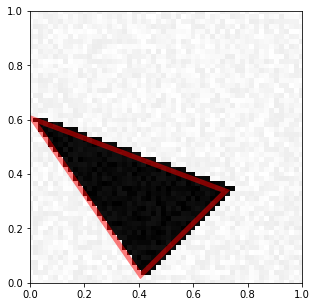

In [263]:
visualize_prediction(X_train[0], Y_train[0])

In [378]:
# Clearing session 
backend.clear_session()

# Graph
model = Sequential([
    BatchNormalization(input_shape=(72, 72, 1)),
    Conv2D(filters=16, kernel_size=(5, 5), kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),
    Flatten(),
    Dense(6),
    Activation('relu')]
) 

# Custom decay
def step_decay(epoch):
    initial_lrate = 0.00001
    drop = 0.5
    epochs_drop = 2
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    print('Learning_rate = {}'.format(lrate))
    return lrate

lrate = callbacks.LearningRateScheduler(step_decay)

# Optimizer
rms = RMSprop()

model.compile(loss=losses.mean_absolute_error, optimizer=rms)

# Callback for tensorboard
toCallback = callbacks.TensorBoard(log_dir='Networks\\Model_4\\logs', batch_size=32,
                                   write_graph=True)

X_train = X_train.reshape(20000, 72, 72, 1)

# Fitting the model
model.fit(x=X_train, y=Y_train, epochs=10, batch_size=16, validation_split=0.1, callbacks=[lrate, toCallback])

# Saving model
model.save('Networks\\Model_4\\Fitted_Network')

Train on 18000 samples, validate on 2000 samples
Learning_rate = 1e-05
Epoch 1/10
18000/18000 [==============================] - 11s 629us/step - loss: 0.3148 - val_loss: 0.2589
Learning_rate = 1e-05
Epoch 2/10
18000/18000 [==============================] - 11s 615us/step - loss: 0.2819 - val_loss: 0.2440
Learning_rate = 5e-06
Epoch 3/10
18000/18000 [==============================] - 11s 615us/step - loss: 0.2647 - val_loss: 0.2383
Learning_rate = 5e-06
Epoch 4/10
18000/18000 [==============================] - 11s 620us/step - loss: 0.2575 - val_loss: 0.2367
Learning_rate = 2.5e-06
Epoch 5/10
18000/18000 [==============================] - 11s 608us/step - loss: 0.2512 - val_loss: 0.2348
Learning_rate = 2.5e-06
Epoch 6/10
18000/18000 [==============================] - 11s 609us/step - loss: 0.2477 - val_loss: 0.2339
Learning_rate = 1.25e-06
Epoch 7/10
18000/18000 [==============================] - 11s 607us/step - loss: 0.2455 - val_loss: 0.2329
Learning_rate = 1.25e-06
Epoch 8/10
18000

Creating data:
0


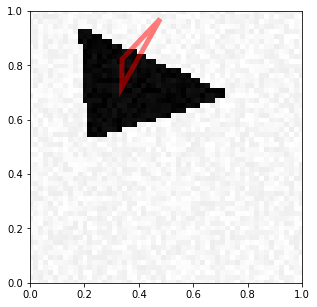

In [386]:
[X_test, Y_test] = generate_dataset_regression(1, 20)
Y_pred = model.predict(X_test.reshape(1, 72, 72, 1))
visualize_prediction(X_test[0], Y_pred[0])

# Hourglass for denoizing

In [17]:
# Generating data
X_train = np.zeros((300, 72*72))
Y_train = np.zeros((300, 72*72))
for _ in range(300):
    X_train[_, :], Y_train[_, :] = generate_a_disk_2(20)
    if _ % 10 == 0:
        print(_)

X_train = X_train / 255
Y_train = Y_train / 255

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


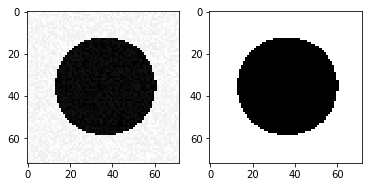

In [18]:
fig, [ax_1, ax_2] = plt.subplots(1,2)
ax_1.imshow(X_train[0,:].reshape(72,72), cmap='gray')
ax_2.imshow(Y_train[0,:].reshape(72,72), cmap='gray')

In [40]:
# Clearing session 
backend.clear_session()

#Basic block
def residual_block(inp):
    
    Normed_Input = BatchNormalization()(inp)
    layer_1 = Conv2D(filters=16, kernel_size=(1, 1), strides=(1,1), activation='relu')(Normed_Input)
    Normed_layer_1 = BatchNormalization()(layer_1)
    layer_2 = Conv2D(filters=16, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu')(Normed_layer_1)
    Normed_layer_2 = BatchNormalization()(layer_2)
    layer_3 = Conv2D(filters=32, kernel_size=(1, 1), strides=(1,1), activation='relu')(Normed_layer_2)
    
    return Add()([layer_3, inp])


def hourgalass(inp, depth):
    
    if depth == 0:
        st = 2
        
    else:
        st = 3
        
    res = residual_block(inp)
    branch_off = residual_block(res)
    pooled = MaxPooling2D(pool_size=(st, st), strides=(st, st), padding='valid')(branch_off)
    
    if depth > 0:
        hourglass_out = hourgalass(pooled, depth-1)
    
    else:
        hourglass_out = residual_block(pooled)
    
    upscaled =  UpSampling2D(size=(st, st))(hourglass_out)
    res_out = residual_block(upscaled)
    
    return Add()([res_out, branch_off])


def Network():
    
    input = Input((72, 72, 1))
    
    Normed_Input = BatchNormalization()(input)
    conv_input = Conv2D(filters=32, kernel_size=(1, 1), strides=(1,1), activation='relu')(Normed_Input)
    
    res_1 = residual_block(conv_input)
    res_2 = residual_block(res_1)
    
    hourglass_out = hourgalass(res_2, 2)
    
    hourglass_normed = BatchNormalization()(hourglass_out)
    heat_map = Conv2D(filters=1, kernel_size=(1, 1), activation='relu')(hourglass_normed)
    
    out = Flatten()(heat_map)
    model = Model(inputs=input, outputs=out)
    
    return model


De_noiser = Network()

# Custom decay
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    print('Learning_rate = {}'.format(lrate))
    return lrate

lrate = callbacks.LearningRateScheduler(step_decay)

# Optimizer
rms = RMSprop()

De_noiser.compile(loss=losses.mean_absolute_error, optimizer=rms)

# Callback for tensorboard
toCallback = callbacks.TensorBoard(log_dir='Networks\\Model_5\\logs', batch_size=32,
                                   write_graph=True)

X_train = X_train.reshape(300, 72, 72, 1)

# Fitting the model
De_noiser.fit(x=X_train, y=Y_train, epochs=200, batch_size=16, validation_split=0.1, callbacks=[lrate, toCallback])

# Saving model
De_noiser.save('Networks\\Model_5\\Fitted_Network')    

Train on 270 samples, validate on 30 samples
Learning_rate = 0.01
Epoch 1/200
270/270 [==============================] - 4s 13ms/step - loss: 0.3690 - val_loss: 0.2497
Learning_rate = 0.01
Epoch 2/200
270/270 [==============================] - 2s 8ms/step - loss: 0.1778 - val_loss: 0.2647
Learning_rate = 0.01
Epoch 3/200
270/270 [==============================] - 2s 8ms/step - loss: 0.1750 - val_loss: 0.7543
Learning_rate = 0.01
Epoch 4/200
270/270 [==============================] - 2s 8ms/step - loss: 0.1263 - val_loss: 0.3824
Learning_rate = 0.01
Epoch 5/200
270/270 [==============================] - 2s 8ms/step - loss: 0.0951 - val_loss: 0.3300
Learning_rate = 0.01
Epoch 6/200
270/270 [==============================] - 2s 8ms/step - loss: 0.1221 - val_loss: 0.5860
Learning_rate = 0.01
Epoch 7/200
270/270 [==============================] - 2s 8ms/step - loss: 0.1022 - val_loss: 0.7674
Learning_rate = 0.01
Epoch 8/200
270/270 [==============================] - 2s 8ms/step - loss: 0.11

Learning_rate = 0.00015625
Epoch 66/200
270/270 [==============================] - 2s 8ms/step - loss: 0.0057 - val_loss: 0.0058
Learning_rate = 0.00015625
Epoch 67/200
270/270 [==============================] - 2s 8ms/step - loss: 0.0053 - val_loss: 0.0038
Learning_rate = 0.00015625
Epoch 68/200
270/270 [==============================] - 2s 8ms/step - loss: 0.0044 - val_loss: 0.0038
Learning_rate = 0.00015625
Epoch 69/200
270/270 [==============================] - 2s 8ms/step - loss: 0.0051 - val_loss: 0.0030
Learning_rate = 0.00015625
Epoch 70/200
270/270 [==============================] - 2s 8ms/step - loss: 0.0050 - val_loss: 0.0033
Learning_rate = 7.8125e-05
Epoch 71/200
270/270 [==============================] - 2s 8ms/step - loss: 0.0043 - val_loss: 0.0041
Learning_rate = 7.8125e-05
Epoch 72/200
270/270 [==============================] - 2s 8ms/step - loss: 0.0042 - val_loss: 0.0033
Learning_rate = 7.8125e-05
Epoch 73/200
270/270 [==============================] - 2s 9ms/step - 

270/270 [==============================] - 2s 9ms/step - loss: 0.0050 - val_loss: 0.0027
Learning_rate = 2.44140625e-06
Epoch 129/200
270/270 [==============================] - 2s 9ms/step - loss: 0.0041 - val_loss: 0.0028
Learning_rate = 2.44140625e-06
Epoch 130/200
270/270 [==============================] - 2s 9ms/step - loss: 0.0039 - val_loss: 0.0027
Learning_rate = 1.220703125e-06
Epoch 131/200
270/270 [==============================] - 2s 9ms/step - loss: 0.0037 - val_loss: 0.0027
Learning_rate = 1.220703125e-06
Epoch 132/200
270/270 [==============================] - 2s 9ms/step - loss: 0.0040 - val_loss: 0.0027
Learning_rate = 1.220703125e-06
Epoch 133/200
270/270 [==============================] - 2s 9ms/step - loss: 0.0041 - val_loss: 0.0027
Learning_rate = 1.220703125e-06
Epoch 134/200
270/270 [==============================] - 2s 9ms/step - loss: 0.0046 - val_loss: 0.0027
Learning_rate = 1.220703125e-06
Epoch 135/200
270/270 [==============================] - 2s 9ms/step - 

270/270 [==============================] - 2s 9ms/step - loss: 0.0041 - val_loss: 0.0027
Learning_rate = 3.814697265625e-08
Epoch 189/200
270/270 [==============================] - 2s 9ms/step - loss: 0.0039 - val_loss: 0.0027
Learning_rate = 3.814697265625e-08
Epoch 190/200
270/270 [==============================] - 2s 9ms/step - loss: 0.0036 - val_loss: 0.0027
Learning_rate = 1.9073486328125e-08
Epoch 191/200
270/270 [==============================] - 2s 9ms/step - loss: 0.0044 - val_loss: 0.0027
Learning_rate = 1.9073486328125e-08
Epoch 192/200
270/270 [==============================] - 2s 9ms/step - loss: 0.0039 - val_loss: 0.0027
Learning_rate = 1.9073486328125e-08
Epoch 193/200
270/270 [==============================] - 2s 9ms/step - loss: 0.0046 - val_loss: 0.0027
Learning_rate = 1.9073486328125e-08
Epoch 194/200
270/270 [==============================] - 2s 9ms/step - loss: 0.0040 - val_loss: 0.0027
Learning_rate = 1.9073486328125e-08
Epoch 195/200
270/270 [====================

NameError: name 'model' is not defined

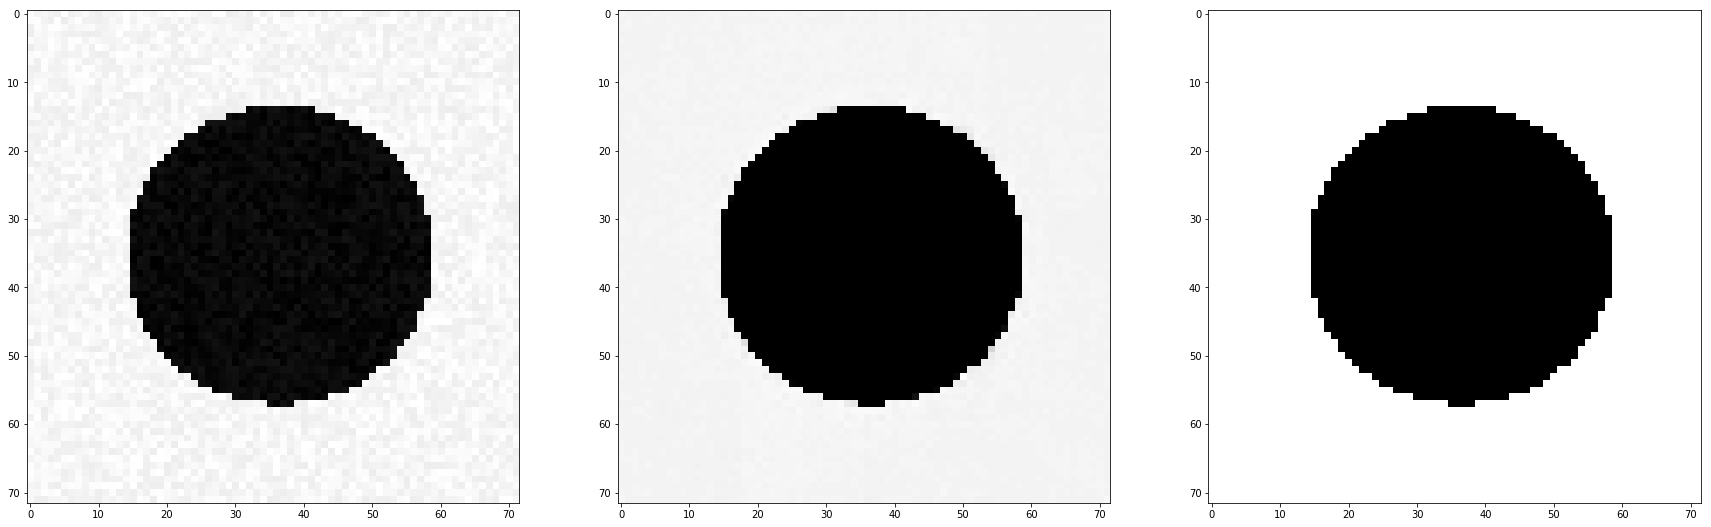

In [49]:
X_test, Y_test =  generate_a_disk_2(20)
X_test = X_test/255
Y_test= Y_test/255
fig, [ax_1, ax_2, ax_3] = plt.subplots(1,3, figsize=(30,10))
ax_1.imshow(X_test.reshape(72,72), cmap='gray')
ax_2.imshow(De_noiser.predict(X_test.reshape(1,72,72,1)).reshape(72,72), cmap='gray')
ax_3.imshow(Y_test.reshape(72,72), cmap='gray')